# Sionna Ray Tracing Tutorial: Coverage Map 

This notebook provides an example of using Sionna RT to generate the coverage map for the target area generated using our scene generation framework. This example contains five modules:

1. **Load and Preview** the generated scene for the target area;
2. **Configure** the transmitters and receivers;
3. **Generate** the coverage map (or path gain map);
4. **Visualize** the results using Sionna's built-in functions;
5. **Plot/Save** the raw coverage map.

Make sure that you have Sionna installed:
```console
python3 -m pip install sionna
```


In [1]:
# Core imports
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray
import numpy as np
import matplotlib.pyplot as plt

## 1. **Load and Preview** the generated scene for the target area

We assume you have a 3D scene XML file generated with our command line tool `scenegen`, check the `README.md` of this repo for details. 

You can use the following controls:
* Mouse left: Rotate
* Scroll wheel: Zoom
* Mouse right: Move


In [3]:
# Replace '../scenes/Boston/scene.xml' with the path to your scene file
scene = load_scene("../scenes/Boston/scene.xml")

# Preview the loaded scene (a quick 3D visualization)
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## 2. **Configure** the transmitters and receivers

Next, we specify:
1. The **transmit (TX)** antenna array is a planar array with a single element and isotropic pattern;
2. The **receive (RX)** antenna array is a planar array with a single element but with a dipole pattern.

Then, we create a `Transmitter` object with a specific position and orientation, and add it to the `scene`.

**Note: Scene geographical coordinate system**
- Coordinate system: Scene center is (0,0,0), the z-axis for the flat ground polygon is 0.
- Units: Meters (m).

**Note: Sionna Azimuth/Elevation Format**
- Sionna defines the **antenna azimuth** in the range [-π, π) [rad]. The following code converts the commonly used **north-origin, clockwise-degree azimuth** to the formate suitable for Sionna. Check the code below for details.

In [4]:
# Transmit array (single iso element)
scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="iso",        # isotropic pattern
    polarization="V"      # vertical polarization
)

# Receive array (single dipole element)
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="dipole",
    polarization="cross"
)

# Create a single transmitter.
# - Positioned at x=0, y=0, z=100, in the unit of meters
# - Orientation toward 210 degree
tx = Transmitter(
    name="tx",
    position=[0, 0, 100],
    orientation=[-1 * (210 - 90) / 180 * np.pi, 0, 0]
)

# Add the transmitter instance to our scene
scene.add(tx)

# Set the operating frequency in Hz (here, 3.65 GHz corresponding to the CBRS band)
scene.frequency = 3.65e9

# Use a synthetic array for faster simulation.
# If set to False, Sionna performs ray tracing per antenna element (slower for large arrays).
scene.synthetic_array = True

## 3. **Generate** the coverage map (or path gain map)

The `coverage_map` method creates a **grid** of RX locations and performs ray tracing to calculate path gain at each grid point. Below, we set:

- `max_depth=5` (maximum number of reflections/refractions/diffractions);
- `diffraction=True` to include diffraction effects;
- `cm_cell_size=(2., 2.)` for a grid resolution of 2×2 meter, i.e., one pixel corresponds to an area of 2m x 2m;
- `cm_size=[512, 512]` specifies that the coverage map covers a total area of 512m × 512m. The corresponding coverage map "image" has a dimension of 256x256.
- `num_samples=int(2e6)` specifies how many rays are sampled (reduce if running out of memory).

**Note**:
Reduce the number of samples if you observe out-of-memory error.

In [5]:
cm = scene.coverage_map(
    max_depth=5,
    diffraction=True,         # Account for diffraction effects
    cm_cell_size=(2., 2.),    # Coverage map grid size in meters
    combining_vec=None,
    cm_center=[0, 0, 1.5],    # Center of the coverage map plane
    cm_orientation=[0, 0, 0], # Orientation of the coverage map plane
    cm_size=[512, 512],       # Size of the coverage map in meters. The number of cells in the x and y directions should be [cm_size / cm_cell_size]
    precoding_vec=None,
    num_samples=int(2e6)      # Number of rays generated (reduce if memory is limited)
)

## 4. **Visualize** the results using Sionna pre-built functions

Sionna supports overlaying the coverage map on top of the target scene. This allows for visual verification of how the path gain results align with the 3D world model. 


In [8]:
scene.preview(coverage_map=cm)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

`cm.show(tx=0)` gives a built-in quick plot for the coverage map of transmitter 0.

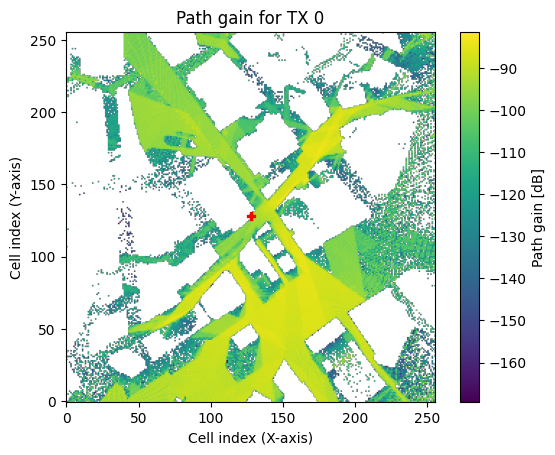

In [9]:
cm.show(tx=0);

## 5. **Plot/Save** the raw coverage map.

Here, we extract the raw **coverage map** data from the Sionna:
- Convert it to a NumPy array.
- Show both the raw linear data, dB scale, and a **flipped** version.

**Note**: Sionna's indexing differs from the conventional coordinate origin assumptions, so flipping the map can help align with your expected orientation. The above function `cm.show()` achieves the same purpose as the `Coverage (dB, Flipped)` function. 

/var/folders/vp/5hq2z3q50pgc5bmx7n1dr1sr0000gn/T/ipykernel_10546/198311334.py:5: RuntimeWarning: divide by zero encountered in log10
  cm_npy_db = 10 * np.log10(cm_npy)
/var/folders/vp/5hq2z3q50pgc5bmx7n1dr1sr0000gn/T/ipykernel_10546/198311334.py:6: RuntimeWarning: divide by zero encountered in log10
  cm_npy_flipped_db = 10 * np.log10(np.flip(cm_npy, 0))


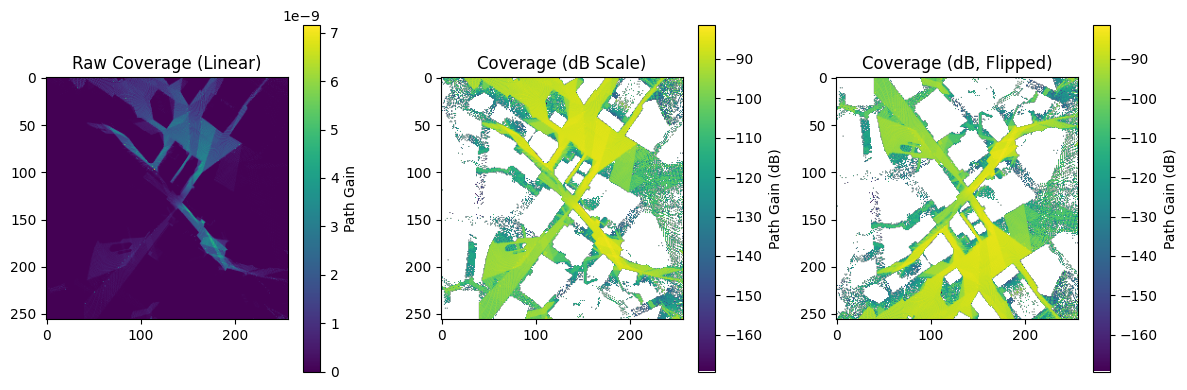

In [10]:
# Extract path gain from the coverage map. shape: (1, height, width)
cm_npy = cm.path_gain.numpy()[0, :, :]

# Convert path gain to dB scale. Also demonstrate flipping along axis 0
cm_npy_db = 10 * np.log10(cm_npy)
cm_npy_flipped_db = 10 * np.log10(np.flip(cm_npy, 0))

# Create side-by-side plots for raw, dB, and flipped dB
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Raw coverage map (linear scale)
im_raw = axes[0].imshow(cm_npy)
axes[0].set_title('Raw Coverage (Linear)')
cbar_raw = plt.colorbar(im_raw, ax=axes[0])
cbar_raw.set_label('Path Gain')

# 2) Coverage map in dB scale
im_db = axes[1].imshow(cm_npy_db)
axes[1].set_title('Coverage (dB Scale)')
cbar_db = plt.colorbar(im_db, ax=axes[1])
cbar_db.set_label('Path Gain (dB)')

# 3) Flipped coverage map in dB scale
im_db_flip = axes[2].imshow(cm_npy_flipped_db)
axes[2].set_title('Coverage (dB, Flipped)')
cbar_db_flip = plt.colorbar(im_db_flip, ax=axes[2])
cbar_db_flip.set_label('Path Gain (dB)')

plt.tight_layout()
plt.show()

**Closing Remark**:
Please fefer to the [Sionna Documentation](https://nvlabs.github.io/sionna/) for more advanced features!